# Blood vessel detection using machine learning

First read in the images and manuals (expert masks):

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.util import view_as_windows
from random import sample
import math
import glob
import cv2

img_filenames = glob.glob("data/images/*")
img_filenames.sort()
images = [cv2.imread(img) for img in img_filenames]

manual_filenames = glob.glob("data/manual1/*")
manual_filenames.sort()
manuals = [cv2.imread(img, 0) for img in manual_filenames]

cols = ['mean', 'std', 'm00', 'm10', 'm01', 'm20', 'm11', 'm02', 'm30', 'm21', 'm12', 'm03', 'mu20', 'mu11', 'mu02', 'mu30', 'mu21', 'mu12', 'mu03', 'nu20', 'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7']

Let's see how the images look like:

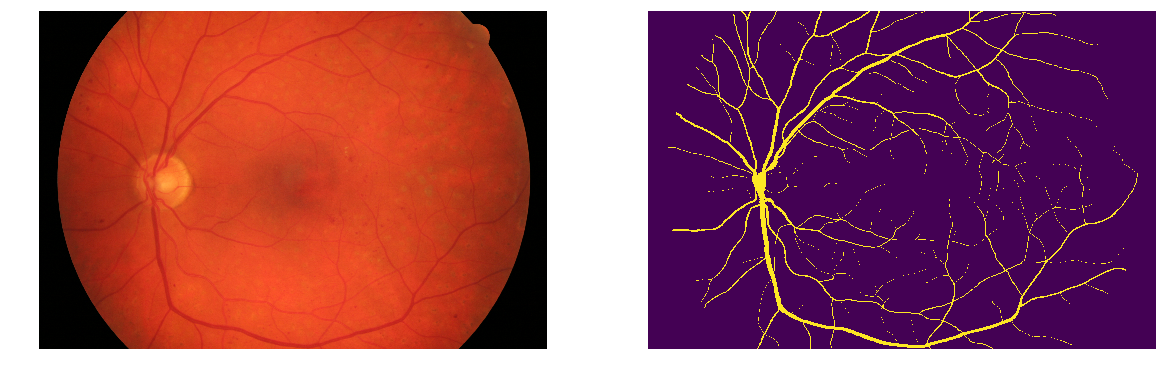

In [52]:
fig, ax = plt.subplots(1,2, figsize=(20,50))

ax[0].imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
ax[1].imshow(manuals[0])
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.savefig("")

Helper functions:

In [35]:
def preprocess_image(image):
    return image[:,:,1]

def get_stats(segment):
    mean = np.mean(segment)
    std = np.std(segment)
    M = cv2.moments(segment)
    moments = np.array(list(M.values()))
    hu = np.array(cv2.HuMoments(M)[:,0])
    return np.hstack([mean, std, moments, hu]).squeeze()    

Function for creating dataset with stats from images:

In [76]:
def create_dataset(images, manuals, size):
    df = pd.DataFrame(columns=cols)
    labels = []
    for img, manual in tqdm(zip(images, manuals)):
        img_pre = preprocess_image(img)
        windows = view_as_windows(img_pre, (size,size), step=size)
        width, height, _, _ = windows.shape
        windows = windows.flatten().reshape(width*height, size, size)

        manual_windows = view_as_windows(manual, (size,size), step=size)
        manual_windows = manual_windows.flatten().reshape(width*height, size, size)
        
        data = list(zip(windows, manual_windows))
        after_sampling = sample(data, 5000)
        
        windows, manual_windows = zip(*after_sampling)
        
        for window in tqdm(windows):
            df = df.append(pd.DataFrame([get_stats(window)], columns=cols), ignore_index = True) 
            
        labels.append([man[math.floor(size/2),math.floor(size/2)]/255 for man in manual_windows])
        break
        
    df['label'] = np.array(labels).flatten()
    return df

train_images, test_images, train_manuals, test_manuals = train_test_split(
     images, manuals, test_size=0.11, random_state=42)

df = create_dataset(train_images, train_manuals, 5) 
df.to_csv("dataset.csv")

#df = read_csv("dataset.csv")

As we're dealing with imbalanced data, we'll use RandomUnderSampler to balance the dataset

In [105]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 42)
X, y = undersample.fit_resample(df[cols], df['label'])

We decided to use LightGBM Classifier, because it is a very fast gradient boosting framework with low memory usage, that uses tree based learning algorithms. We train the model on whole created dataset and test it below, on windows from the hold out dataset.

In [106]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgb = LGBMClassifier(objective='binary', scale_pos_weight=0.99, random_state=42)
lgb.fit(X, y)

0.8034337771548704

Functions used for testing (note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”)

In [114]:
def gen_test_image(image, manual, x_start, x_end, y_start, y_end):
    df_test = pd.DataFrame(columns=cols)
    
    img_pre = preprocess_image(image)
    windows = view_as_windows(img_pre, (5,5), step=1)
    windows = windows[x_start:x_end, y_start:y_end]
    for window in tqdm(windows):
        for w in window:
            df_test = df_test.append(pd.DataFrame([get_stats(w)], columns=cols), ignore_index = True) 
            
    manual_windows = view_as_windows(manual, (5,5), step=1)
    manual_windows = manual_windows[x_start:x_end, y_start:y_end]
    
    labels_test = []
    for manual_window in manual_windows:
        labels_test.append([man[2,2]/255 for man in manual_window])
    
    df_test['label'] = np.array(labels_test).flatten()
    
    return df_test

def test_model(model, df_test, x_size, y_size):
    predicted = model.predict(df_test[cols])
    print(classification_report(df_test['label'], predicted))
    
    predicted_re = predicted.reshape(x_size, y_size)
    im = np.array(predicted_re * 255, dtype = np.uint8)
    (_, threshed_predict) = cv2.threshold(im, 0, 1, cv2.THRESH_BINARY)
    
    labels_test_img = np.array(df_test['label']).reshape(x_size, y_size)
    im = np.array(labels_test_img * 255, dtype = np.uint8)
    (_, threshed_mask) = cv2.threshold(im, 0, 1, cv2.THRESH_BINARY)
    
    fig, ax = plt.subplots(1,2, figsize=(20,50))

    ax[0].imshow(threshed_mask)
    ax[1].imshow(threshed_predict)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88    115275
         1.0       0.84      0.38      0.52     44725

    accuracy                           0.81    160000
   macro avg       0.82      0.67      0.70    160000
weighted avg       0.81      0.81      0.78    160000



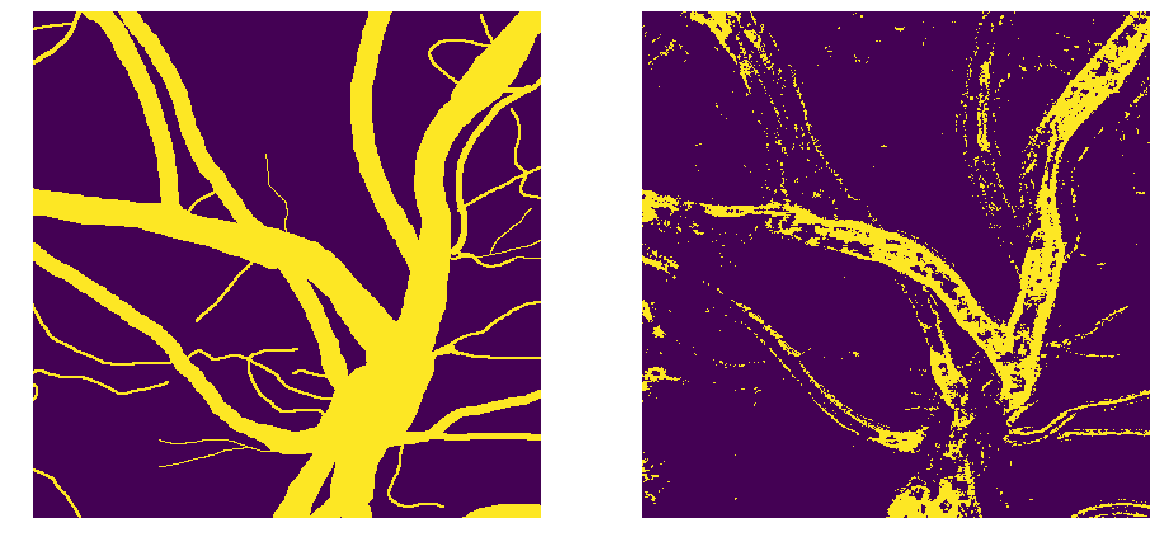

In [117]:
x_start, x_end = 800, 1200
y_start, y_end = 600, 1000

# df_test = gen_test_image(test_images[0], test_manuals[0], x_start, x_end, y_start, y_end)
# df_test.to_csv("df_test.csv")

# df = read_csv("df_test.csv")
test_model(lgb, df_test, x_end - x_start, y_end - y_start)

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86    125834
         1.0       0.51      0.58      0.54     34166

    accuracy                           0.79    160000
   macro avg       0.70      0.71      0.70    160000
weighted avg       0.80      0.79      0.80    160000



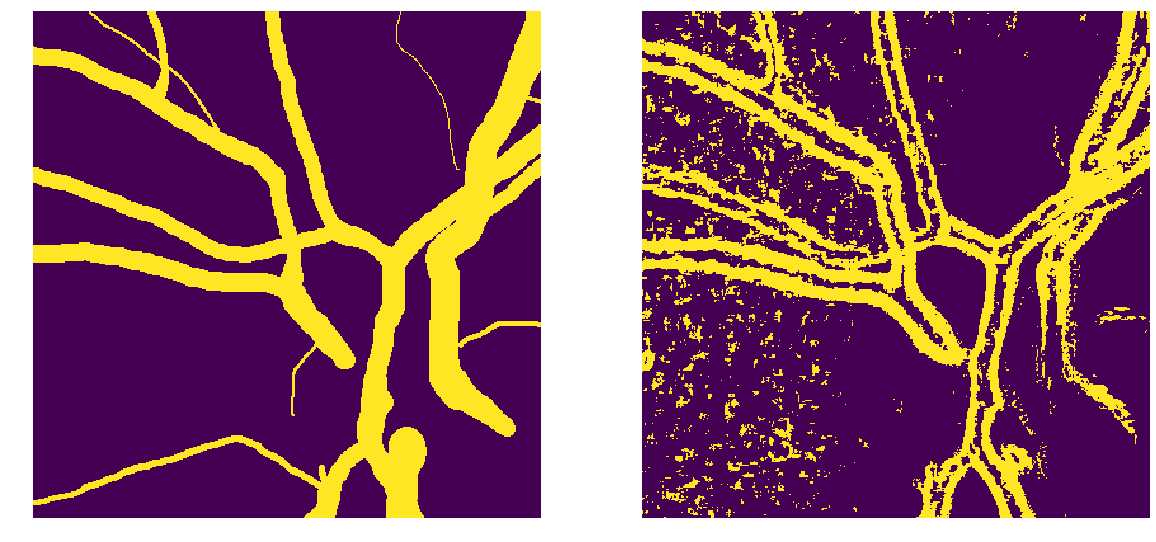

In [118]:
# df_test2 = gen_test_image(test_images[1], test_manuals[1], x_start, x_end, y_start, y_end)
# df_test2.to_csv("df_test2.csv")

# df = read_csv("df_test2.csv")
test_model(lgb, df_test2, x_end - x_start, y_end - y_start)